# Evaluate Primary Site and Tumor Normal Classifier

In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)  # reproducibility

# Switch to a scratch data directory so all paths are local
os.makedirs(os.path.expanduser("~/data/pancan-gtex"), exist_ok=True)
os.chdir(os.path.expanduser("~/data/pancan-gtex"))

# Load Trained Model and Test Data

In [2]:
# Load the model and predict the test set
model = tf.keras.models.model_from_json(open("models/pancan-gtex-hugo-model.json").read())
model.load_weights("models/pancan-gtex-hugo-weights.h5")
params = json.loads(open("models/pancan-gtex-hugo-params.json").read())

In [3]:
# print(sorted(params["hyperparameters"], key=lambda r: r["loss"])[0])

print("Number of genes:", len(params["genes"]))

Number of genes: 5169


In [4]:
%%time
X_all = pd.read_hdf("pancan-gtex-hugo.h5", "samples")
Y = pd.read_hdf("pancan-gtex-hugo.h5", "labels")
print("Loaded {} samples with {} features and {} labels".format(X_all.shape[0], X_all.shape[1], Y.shape[1]))

Loaded 17277 samples with 44792 features and 40 labels
CPU times: user 363 ms, sys: 3.35 s, total: 3.71 s
Wall time: 3.71 s


In [5]:
X_all.head()

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU18,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338
GTEX-1117F-0226-SM-5GZZ7,16.526960,0.0,0.384606,20.509176,1.541947,0.071938,178.459763,1.697192,1.282659,0.0,...,0.0,0.000000,0.0,0.0,8.115175,0.0,0.0,0.0,0.0,143.755127
GTEX-1117F-0426-SM-5EGHI,16.938061,0.0,0.000000,2.618070,0.318152,0.054464,68.531693,0.256046,1.936022,0.0,...,0.0,5.094416,0.0,0.0,11.733626,0.0,0.0,0.0,0.0,40.552704
GTEX-1117F-0526-SM-5EGHJ,18.733189,0.0,0.353879,35.434528,1.632554,0.072991,1021.440918,0.960461,0.992336,0.0,...,0.0,0.000000,0.0,0.0,8.005656,0.0,0.0,0.0,0.0,112.833725
GTEX-1117F-0626-SM-5N9CS,23.643007,0.0,1.001808,42.133961,5.800933,0.030382,862.619568,3.505909,1.380795,0.0,...,0.0,0.000000,0.0,0.0,11.501695,0.0,0.0,0.0,0.0,112.928238
GTEX-1117F-0726-SM-5GIEN,9.548916,0.0,0.236544,23.710445,2.189925,0.045214,227.612228,0.903567,0.931574,0.0,...,0.0,0.000000,0.0,0.0,12.039304,0.0,0.0,0.0,0.0,61.048901


In [6]:
# Convert tumor normal and primary site to numeric values so we can plot confusion and errors againsts them
from sklearn.preprocessing import LabelEncoder

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(primary_site_encoder.fit_transform(Y["_primary_site"]), index=Y.index)

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

In [7]:
Y._primary_site.value_counts()

Brain                   1846
Lung                    1410
Breast                  1391
Kidney                  1043
Skin                    1026
Esophagus                848
Prostate                 648
Colon                    639
Stomach                  624
Blood Vessel             606
Thyroid Gland            571
Head and Neck region     564
Liver                    531
Adipose Tissue           515
Ovary                    515
Bladder                  435
Muscle                   396
Heart                    377
Pancreas                 350
Blood                    337
Testis                   319
Cervix                   309
Thyroid                  279
Nerve                    278
Soft tissue,Bone         264
Endometrium              204
Paraganglia              185
White blood cell         173
Uterus                   135
Adrenal Gland            128
Thymus                   121
Pituitary                107
Rectum                   103
Name: _primary_site, dtype: int64

In [8]:
# Prune so we match the training
X = X_all.drop(labels=(set(X_all.columns) - set(params["genes"])), axis=1)
print("Pruned features down to {} genes".format(X.shape[1]))

X_train = X.values[params["train_indices"]]
Y_train = Y.iloc[params["train_indices"]]

X_test = X.values[params["test_indices"]]
Y_test = Y.iloc[params["test_indices"]]

Pruned features down to 5169 genes


In [9]:
# Predict all test samples
predictions = model.predict(X_test)

## Evaluate

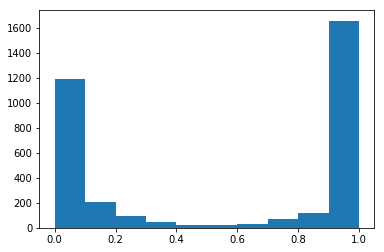

Tumor/Normal Confusion Matrix
[[1531   38]
 [  20 1867]]


In [10]:
# Plot the distribution of tumor/normal values and confusion matrix
plt.hist(predictions[:,0])
plt.show()

from sklearn.metrics import confusion_matrix
print("Tumor/Normal Confusion Matrix")
print(confusion_matrix(Y_test["tumor_normal_value"], np.round(predictions[:,0])))

In [11]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix optionally normalized by class size
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

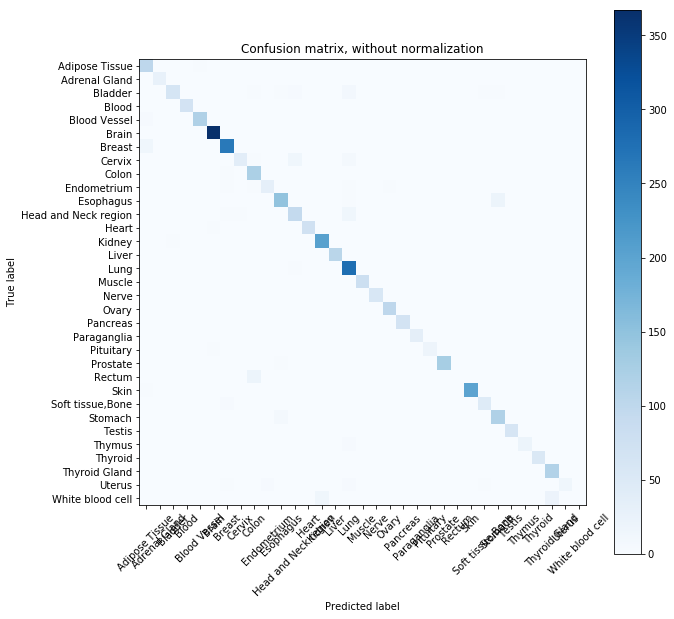

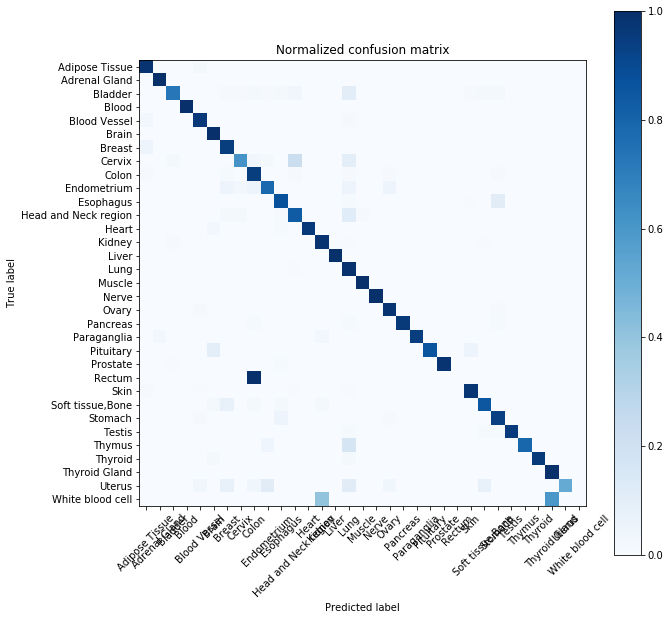

In [12]:
# Plot confusion matrix for primary site
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    Y_test["primary_site_value"], np.array([np.argmax(p[1:-1]) for p in predictions]))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()